---
## 1. UC Irvine machine learning repositoryからデータセットをダウンロードして解凍

 `! `を付けるとshellを動かせるらしいが、パスが通っていないとエラーになる。
~~~
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
!unzip -o filename
↓
'wget' は、内部コマンドまたは外部コマンド、操作可能なプログラムまたはバッチ ファイルとして認識されていません。
~~~

In [1]:
import wget
import zipfile

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip'
dataDir = './/Data//'
zipFile = 'student.zip'
extractDir = './/Data//01_//'

#### 何度もダウンロードするとファイル名の末尾に「（1）」が追加されるため、下のセルはmarkdownセルにしておく。
#### -------------------------- プログラム
filename = wget.download(url, dataDir + zipFile)
display(filename)

with zipfile.ZipFile(dataDir + zipFile,"r") as zip_ref:
    zip_ref.extractall(extractDir)
print("Finish extracting.")

---
## 2. DataFrameにロード

  - Portuguese language courseのcsvをロードする。
  - レコードは`;`で連結されている。

In [21]:
import pandas as pd
filename = extractDir + 'student-por.csv'
df01 = pd.read_csv(filename, sep=";")
display(df01.head(5))
display(df01.shape)

0    0
1    0
2    0
3    0
4    0
Name: failures, dtype: int64

(649, 33)

---
## 3. G1,G2,G3の列の値を元に合否列を計算し、pass列に結果を保存

### 3-1. 合否を計算
- G1,G2,G3は生徒のポルトガル語の各グレード毎の得点とみなし、合計が35以上の場合に合格とする。
  - 35未満⇒0、35以上⇒1
  - student.txtには以下の説明がある。
  
~~~
these grades are related with the course subject, Math or Portuguese:
  - G1 - first period grade (numeric: from 0 to 20)
  - G2 - second period grade (numeric: from 0 to 20)
  - G3 - final grade (numeric: from 0 to 20, output target)
~~~

In [3]:
df01['pass'] = df01.apply(lambda row: 1 if (row['G1']+row['G2']+row['G3']) >= 35 else 0, axis=1)
display(df01.head(5))
display(df01.shape)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,pass
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,4,0,11,11,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,2,9,11,11,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,6,12,13,12,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,0,14,14,14,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,0,11,13,13,1


(649, 34)

### 3-2. G1,G2,G3の列を削除しておく。

In [4]:
df01 = df01.drop(['G1', 'G2', 'G3'], axis=1)
display(df01.shape)

(649, 31)

### 3-3. 合格者の割合を確認

In [5]:
import numpy as np
df_pass = df01['pass']
print("Passing: %d out of %d (%.2f%%)" % (np.sum(df_pass), len(df_pass), 100*float(np.sum(df_pass)) / len(df_pass)))

Passing: 328 out of 649 (50.54%)


---
## 4. カテゴリー変数が使われている列を分解し、0と1（One-Hot）で表現する。

In [6]:
df02 = pd.get_dummies(df01, columns=['sex', 'school', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 
                                   'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
                                   'nursery', 'higher', 'internet', 'romantic'])
display(df02.head(5))
display(df02.shape)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


(649, 57)

---
## 5. サンプリングして、トレーニング用データとテスト用データを生成する

### 5-1. DataFrameをシャッフルする。

In [7]:
df03 = df02.sample(frac=1)
#display(df03.head(5))
display(df03.shape)

(649, 57)

### 5-2. 最初(index = 0)から500行(index = 499)をトレーニング用データとして、残りをテスト用データとして保存。

In [8]:
df_train = df03[:500]
#display(df_train.head(5))
print('df_train.shape : '+ str(df_train.shape))

df_test = df03[500:]
#display(df_test.head(5))
print('df_test.shape : '+ str(df_test.shape))

df_train.shape : (500, 57)
df_test.shape : (149, 57)


### 5-3. トレーニング用データ、テスト用データそれぞれを、属性データとラベルデータに分けておく。

In [23]:
df_train_att = df_train.drop(['pass'], axis=1)
df_train_label = df_train['pass']
print('df_train_att.shape : '+ str(df_train_att.shape))
print('df_train_label.shape : '+ str(df_train_label.shape))

df_test_att = df_test.drop(['pass'], axis=1)
df_test_label = df_test['pass']
print('df_test_att.shape : '+ str(df_test_att.shape))
print('df_test_label.shape : '+ str(df_test_label.shape))

df_train_att.shape : (500, 56)
df_train_label.shape : (500,)
df_test_att.shape : (149, 56)
df_test_label.shape : (149,)


---
## 6. 決定木作成

  - パッケージをインストール
~~~
conda install python-graphviz
~~~
  - パッケージのイントール先の環境パスを通す
~~~
C:\Users\***\AppData\Local\Continuum\anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz
~~~

### 6-1. 決定木作成

In [33]:
from sklearn import tree
import graphviz

# 分類機の定義
t = tree.DecisionTreeClassifier(
    criterion="entropy", # 分割に使用する品質。ジニ係数m⇒“gini”／情報量⇒“entropy”
    max_depth=5          # 決定木の深さの最大値。
    )

# 決定木作成
t = t.fit(df_train_att, df_train_label)
display(t)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### 6-2. 決定木をグラフ化

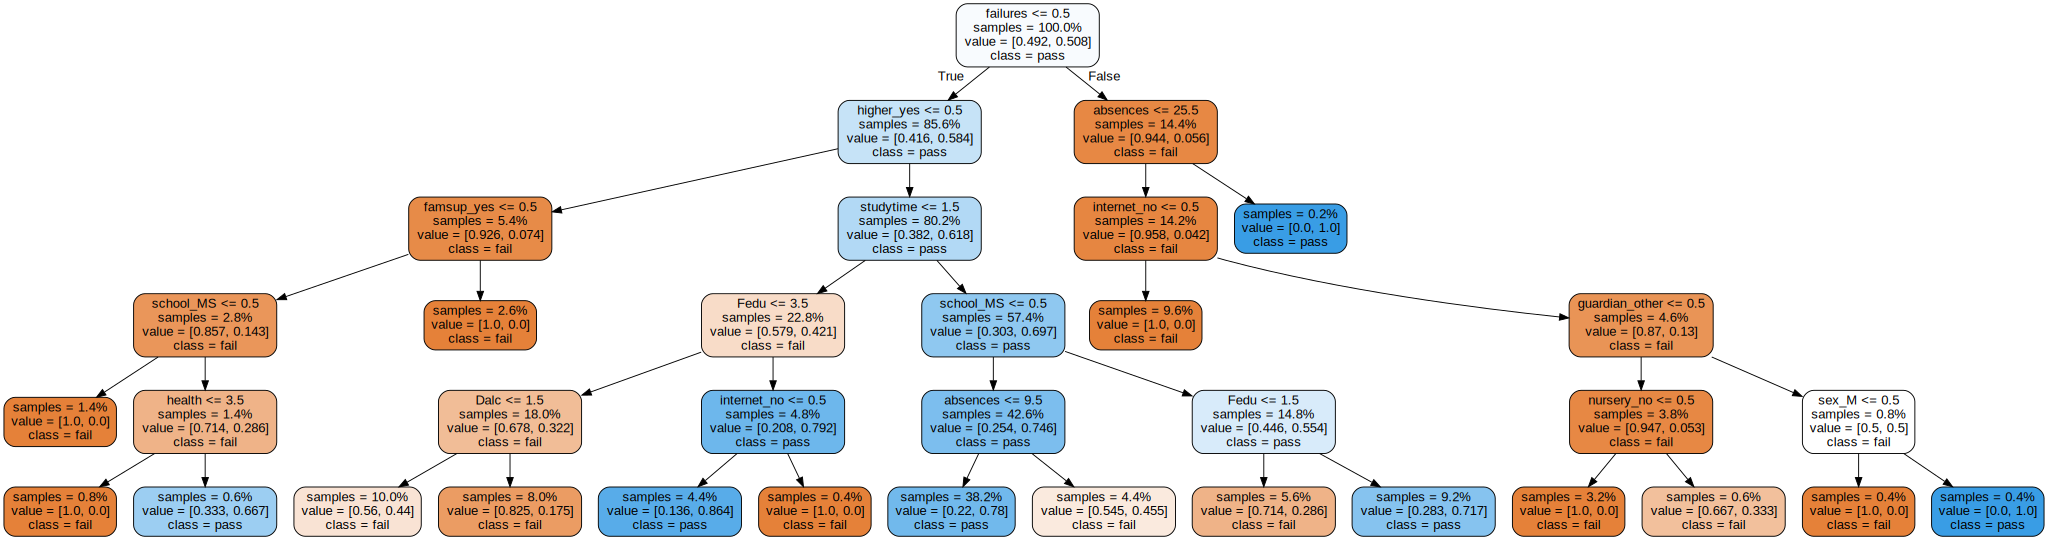

In [34]:
dot_data = tree.export_graphviz(
    t,              # 決定木オブジェクト指定
    out_file=None, # ファイルは介さずにGraphvizにdot言語データを渡すのでNone
    label="all", #
    impurity=False, #
    proportion=True, #
    feature_names=list(df_train_att), # これを指定しないとチャート上で特徴量の名前が表示されない
    class_names=["fail", "pass"], # これを指定しないとチャート上で分類名が表示されない
    filled=True, # Trueにすると、分岐の際にどちらのノードに多く分類されたのか色で示してくれる
    rounded=True #
    )
graph = graphviz.Source(dot_data)
graph

### 6-3. ファイルに保存

In [37]:
tree.export_graphviz(
    t,
    out_file= extractDir + "student-performance.dot",
    label="all",
    impurity=False,
    proportion=True,
    feature_names=list(df_train_att), 
    class_names=["fail", "pass"], 
    filled=True,
    rounded=True)

In [39]:
t.score(df_test_att, df_test_label)

0.6442953020134228